In [29]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# 1. Muat Dataset (Ganti 'nama_dataset_anda.csv' dengan nama file Anda)
try:
    df = pd.read_csv('New Dataset_.csv')
    print("Dataset berhasil dimuat.")
    print(df.head())
    print(df.info())
except FileNotFoundError:
    print("Error: File dataset tidak ditemukan. Pastikan nama file dan path sudah benar.")
    exit()

Dataset berhasil dimuat.
                                   Flow ID         Src IP  Src Port  \
0  192.168.45.220-192.168.45.53-22-48782-6  192.168.45.53     48782   
1  192.168.45.220-192.168.45.53-22-48930-6  192.168.45.53     48930   
2  192.168.45.220-192.168.45.53-22-48860-6  192.168.45.53     48860   
3  192.168.45.220-192.168.45.53-22-48946-6  192.168.45.53     48946   
4  192.168.45.220-192.168.45.53-22-48872-6  192.168.45.53     48872   

           Dst IP  Dst Port  Protocol               Timestamp  Flow Duration  \
0  192.168.45.220        22         6  27/05/2025 06:03:02 PM         103770   
1  192.168.45.220        22         6  27/05/2025 06:03:02 PM       12722450   
2  192.168.45.220        22         6  27/05/2025 06:03:02 PM       12723354   
3  192.168.45.220        22         6  27/05/2025 06:03:02 PM       12719284   
4  192.168.45.220        22         6  27/05/2025 06:03:02 PM       12724101   

   Tot Fwd Pkts  Tot Bwd Pkts  ...  Fwd Seg Size Min  Active Mean  

In [32]:
import pandas as pd

df = pd.read_csv('New Dataset_.csv')
print(df.columns.tolist())

['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'F

In [33]:
# --- 2. Definisikan Fitur dan Target ---
# Tentukan fitur numerik yang memang ada di dataset kamu
numerical_features = [
    'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
    'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
    'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
    'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
    'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
    'Fwd Header Len', 'Bwd Header Len', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
    'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt',
    'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
    'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
    'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
    'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min',
    'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std',
    'Idle Max', 'Idle Min'
]

# Fitur kategorikal (jika ada — kamu hanya punya 'Protocol', bisa dianggap kategorikal)
categorical_features = ['Protocol']

# Kolom target
target = 'Label'

# Cek apakah semua kolom tersedia
all_features = numerical_features + categorical_features + [target]
missing_cols = [col for col in all_features if col not in df.columns]
if missing_cols:
    print(f"Error: Kolom berikut tidak ditemukan di dataset Anda: {missing_cols}")
    print("Harap sesuaikan 'numerical_features', 'categorical_features', dan 'target' dengan kolom aktual di dataset Anda.")
    exit()

# Pisahkan fitur dan label
X = df[numerical_features + categorical_features]
y = df[target]

In [34]:
import pandas as pd

# Daftar file CSV
file_list = [
    'New Dataset_.csv'
]

# Gabungkan semua file menjadi satu dataframe
df_list = []
for file_name in file_list:
    try:
        df_temp = pd.read_csv(file_name)
        df_list.append(df_temp)
        print(f"Berhasil baca: {file_name}")
    except Exception as e:
        print(f"Gagal baca {file_name}: {e}")

# Satukan semua dataframe
df = pd.concat(df_list, ignore_index=True)
print(f"\nTotal data: {df.shape}")

# Definisikan fitur numerik dan kategorikal berdasarkan kolom yang tersedia di dataset
numerical_features = [
    'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
    'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
    'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
    'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
    'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
    'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
    'Bwd IAT Min', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
    'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
    'ACK Flag Cnt', 'URG Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
    'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Header Len', 'Bwd Header Len',
    'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
    'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min',
    'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
    'Down/Up Ratio', 'CWE Flag Count', 'ECE Flag Cnt'
]

# Kolom kategorikal
categorical_features = ['Protocol']

# Target
target = 'Label'

# Cek apakah semua fitur dan target ada di dataframe
all_features = numerical_features + categorical_features + [target]
missing_cols = [col for col in all_features if col not in df.columns]

if missing_cols:
    print(f"\n⚠️ Kolom berikut tidak ditemukan dalam dataset: {missing_cols}")
else:
    # Jika semua kolom tersedia
    X = df[numerical_features + categorical_features]
    y = df[target]
    print("\n✅ Fitur dan target berhasil dipisahkan.")


Berhasil baca: New Dataset_.csv

Total data: (706791, 84)

✅ Fitur dan target berhasil dipisahkan.


In [35]:
print(df.columns.tolist())

['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'F

In [36]:
# 3. Preprocessing Data Menggunakan Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat transformer untuk fitur numerik (StandardScaler)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Buat transformer untuk fitur kategorikal (OneHotEncoder)
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Gabungkan transformer menggunakan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [37]:
print("Shape X:", X.shape)
print("Type X:", type(X))

Shape X: (706791, 65)
Type X: <class 'pandas.core.frame.DataFrame'>


In [38]:
print(X_train[numerical_features].dtypes)

Flow Duration         int64
Tot Fwd Pkts          int64
Tot Bwd Pkts          int64
TotLen Fwd Pkts     float64
TotLen Bwd Pkts     float64
                     ...   
Subflow Bwd Pkts      int64
Subflow Bwd Byts      int64
Down/Up Ratio       float64
CWE Flag Count        int64
ECE Flag Cnt          int64
Length: 64, dtype: object


In [39]:
X_train[numerical_features] = X_train[numerical_features].apply(pd.to_numeric, errors='coerce')
X_test[numerical_features] = X_test[numerical_features].apply(pd.to_numeric, errors='coerce')

In [40]:
print(X_train[numerical_features].isnull().sum())
print(X_train[categorical_features].isnull().sum())

Flow Duration       0
Tot Fwd Pkts        0
Tot Bwd Pkts        0
TotLen Fwd Pkts     0
TotLen Bwd Pkts     0
                   ..
Subflow Bwd Pkts    0
Subflow Bwd Byts    0
Down/Up Ratio       0
CWE Flag Count      0
ECE Flag Cnt        0
Length: 64, dtype: int64
Protocol    0
dtype: int64


In [41]:
print("Numerik:", numerical_features)
print("\nKategori:", categorical_features)

Numerik: ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow 

In [42]:
print(X_train.shape)
print(X_train.head())

(565432, 65)
        Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
576504            321             0             2              0.0   
233877             11             0             2              0.0   
201208            265             0             2              0.0   
670786            102             0             2              0.0   
405902            106             0             2              0.0   

        TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  Fwd Pkt Len Mean  \
576504              0.0              0.0              0.0               0.0   
233877              0.0              0.0              0.0               0.0   
201208              0.0              0.0              0.0               0.0   
670786              0.0              0.0              0.0               0.0   
405902              0.0              0.0              0.0               0.0   

        Fwd Pkt Len Std  Bwd Pkt Len Max  ...  Idle Max  Idle Min  \
576504              0.

In [44]:
print(df.columns)

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE 

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf

# Misalnya df sudah ada dan memiliki kolom 'label'
X = df.drop('Label', axis=1)
y = df['Label']

# Tangani nilai inf/-inf dan NaN
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

# Tentukan fitur numerik dan kategorikal
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Buat preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# --- 4. Bagi Data menjadi Data Latih dan Data Uji ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Terapkan preprocessing ke data latih dan uji
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Konversi label target ke bentuk numerik (jika perlu) dan lakukan one-hot encoding
label_encoder = tf.keras.layers.StringLookup(
    vocabulary=np.unique(y_train), output_mode='int'
)

# Gunakan .numpy() untuk mendapatkan array indeks label numerik
y_train_encoded = label_encoder(y_train).numpy()
y_test_encoded = label_encoder(y_test).numpy()

num_classes = len(label_encoder.get_vocabulary())

# One-hot encode
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

# Cek hasil
print(f"Bentuk data latih setelah preprocessing: {X_train_processed.shape}")
print(f"Bentuk label latih setelah one-hot encoding: {y_train_one_hot.shape}")


Bentuk data latih setelah preprocessing: (565432, 473883)
Bentuk label latih setelah one-hot encoding: (565432, 6)


I0000 00:00:1748948381.135885  453216 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1748948381.157086  453216 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31553 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:16:00.0, compute capability: 8.9
I0000 00:00:1748948381.157937  453216 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 1
I0000 00:00:1748948381.159876  453216 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 40718 MB memory:  -> device: 1, name: NVIDIA L40S, pci bus id: 0000:be:00.0, compute capability: 8.9


In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# --- 5. Build Model ---
model = Sequential([
    Dense(128, input_shape=(X_train_processed.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_one_hot.shape[1], activation='softmax')  # for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/opt/tljh/user/envs/dltf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_dnn(input_shape, output_shape):
    model = Sequential([
        Dense(128, input_shape=(input_shape,), activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm(input_shape, output_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout

def build_bigru(input_shape, output_shape):
    model = Sequential([
        Bidirectional(GRU(64, return_sequences=False), input_shape=input_shape),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(output_shape, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [54]:
from sklearn.decomposition import TruncatedSVD

# Turunkan dimensi jadi 200 (bisa disesuaikan)
svd = TruncatedSVD(n_components=200, random_state=42)
X_reduced = svd.fit_transform(X_train_processed)


In [55]:
# DNN (bisa pakai X_train_processed atau X_reduced)
dnn_model = build_dnn(X_reduced.shape[1], y_train_one_hot.shape[1])
history_dnn = dnn_model.fit(X_reduced, y_train_one_hot, epochs=20, batch_size=256, validation_split=0.2)

# Untuk LSTM dan BiGRU
X_train_seq = X_reduced.reshape((X_reduced.shape[0], 1, X_reduced.shape[1]))

# LSTM
lstm_model = build_lstm((X_train_seq.shape[1], X_train_seq.shape[2]), y_train_one_hot.shape[1])
history_lstm = lstm_model.fit(X_train_seq, y_train_one_hot, epochs=20, batch_size=256, validation_split=0.2)

# BiGRU
bigru_model = build_bigru((X_train_seq.shape[1], X_train_seq.shape[2]), y_train_one_hot.shape[1])
history_bigru = bigru_model.fit(X_train_seq, y_train_one_hot, epochs=20, batch_size=256, validation_split=0.2)


Epoch 1/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9845 - loss: 0.1002 - val_accuracy: 0.9968 - val_loss: 0.0108
Epoch 2/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9969 - loss: 0.0102 - val_accuracy: 0.9978 - val_loss: 0.0056
Epoch 3/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9980 - loss: 0.0056 - val_accuracy: 0.9981 - val_loss: 0.0048
Epoch 4/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9983 - loss: 0.0043 - val_accuracy: 0.9980 - val_loss: 0.0048
Epoch 5/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9983 - loss: 0.0047 - val_accuracy: 0.9984 - val_loss: 0.0044
Epoch 6/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9984 - loss: 0.0038 - val_accuracy: 0.9983 - val_loss: 0.0044
Epoch 7/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9984 - loss: 0.0042 - val_accuracy: 0.9982 - val_loss: 0.0043
Epoch 8/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9984 - loss

/opt/tljh/user/envs/dltf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.9815 - loss: 0.1622 - val_accuracy: 0.9967 - val_loss: 0.0107
Epoch 2/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9969 - loss: 0.0102 - val_accuracy: 0.9969 - val_loss: 0.0092
Epoch 3/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9973 - loss: 0.0078 - val_accuracy: 0.9979 - val_loss: 0.0055
Epoch 4/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9981 - loss: 0.0052 - val_accuracy: 0.9984 - val_loss: 0.0043
Epoch 5/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9986 - loss: 0.0037 - val_accuracy: 0.9984 - val_loss: 0.0043
Epoch 6/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9985 - loss: 0.0039 - val_accuracy: 0.9984 - val_loss: 0.0041
Epoch 7/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9985 - loss: 0.0037 - val_accuracy: 0.9984 - val_loss: 0.0042
Epoch 8/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9986 -

/opt/tljh/user/envs/dltf/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9761 - loss: 0.1072 - val_accuracy: 0.9969 - val_loss: 0.0104
Epoch 2/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.9970 - loss: 0.0102 - val_accuracy: 0.9968 - val_loss: 0.0078
Epoch 3/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.9975 - loss: 0.0070 - val_accuracy: 0.9981 - val_loss: 0.0048
Epoch 4/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9986 - loss: 0.0040 - val_accuracy: 0.9984 - val_loss: 0.0042
Epoch 5/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9985 - loss: 0.0037 - val_accuracy: 0.9984 - val_loss: 0.0043
Epoch 6/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.9985 - loss: 0.0041 - val_accuracy: 0.9984 - val_loss: 0.0042
Epoch 7/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.9986 - loss: 0.0036 - val_accuracy: 0.9985 - val_loss: 0.0041
Epoch 8/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.9986 -

In [56]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, random_state=42)
X_reduced = svd.fit_transform(X_train_processed)

In [57]:
from tensorflow.keras import models, layers

def build_dnn(input_dim, output_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_shape, output_dim):
    model = models.Sequential([
        layers.LSTM(64, input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_bigru(input_shape, output_dim):
    model = models.Sequential([
        layers.Bidirectional(layers.GRU(64), input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [58]:
dnn_model = build_dnn(X_reduced.shape[1], y_train_one_hot.shape[1])
history_dnn = dnn_model.fit(
    X_reduced,
    y_train_one_hot,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9926 - loss: 0.0830 - val_accuracy: 0.9967 - val_loss: 0.0100
Epoch 2/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9975 - loss: 0.0086 - val_accuracy: 0.9981 - val_loss: 0.0057
Epoch 3/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9984 - loss: 0.0045 - val_accuracy: 0.9982 - val_loss: 0.0052
Epoch 4/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9984 - loss: 0.0042 - val_accuracy: 0.9984 - val_loss: 0.0048
Epoch 5/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9986 - loss: 0.0038 - val_accuracy: 0.9984 - val_loss: 0.0044
Epoch 6/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9986 - loss: 0.0037 - val_accuracy: 0.9983 - val_loss: 0.0047
Epoch 7/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9985 - loss: 0.0037 - val_accuracy: 0.9984 - val_loss: 0.0048
Epoch 8/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9985 - loss: 0

In [59]:
X_seq = X_reduced.reshape((X_reduced.shape[0], 1, X_reduced.shape[1]))  # timesteps = 1

lstm_model = build_lstm((X_seq.shape[1], X_seq.shape[2]), y_train_one_hot.shape[1])
history_lstm = lstm_model.fit(
    X_seq,
    y_train_one_hot,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9763 - loss: 0.2553 - val_accuracy: 0.9969 - val_loss: 0.0120
Epoch 2/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.9970 - loss: 0.0110 - val_accuracy: 0.9970 - val_loss: 0.0101
Epoch 3/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - accuracy: 0.9969 - loss: 0.0094 - val_accuracy: 0.9970 - val_loss: 0.0088
Epoch 4/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9975 - loss: 0.0075 - val_accuracy: 0.9980 - val_loss: 0.0065
Epoch 5/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.9981 - loss: 0.0056 - val_accuracy: 0.9982 - val_loss: 0.0050
Epoch 6/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9984 - loss: 0.0045 - val_accuracy: 0.9984 - val_loss: 0.0048
Epoch 7/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9985 - loss: 0.0039 - val_accuracy: 0.9986 - val_loss: 0.0045
Epoch 8/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9986 -

In [60]:
bigru_model = build_bigru((X_seq.shape[1], X_seq.shape[2]), y_train_one_hot.shape[1])
history_bigru = bigru_model.fit(
    X_seq,
    y_train_one_hot,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.9829 - loss: 0.1343 - val_accuracy: 0.9968 - val_loss: 0.0112
Epoch 2/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9970 - loss: 0.0104 - val_accuracy: 0.9967 - val_loss: 0.0101
Epoch 3/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9970 - loss: 0.0093 - val_accuracy: 0.9974 - val_loss: 0.0084
Epoch 4/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9977 - loss: 0.0070 - val_accuracy: 0.9980 - val_loss: 0.0059
Epoch 5/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - accuracy: 0.9982 - loss: 0.0048 - val_accuracy: 0.9980 - val_loss: 0.0051
Epoch 6/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.9985 - loss: 0.0042 - val_accuracy: 0.9984 - val_loss: 0.0048
Epoch 7/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.9986 - loss: 0.0036 - val_accuracy: 0.9985 - val_loss: 0.0045
Epoch 8/20
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.9987 -

[DNN] Loss: 0.0038 | Akurasi: 99.85%


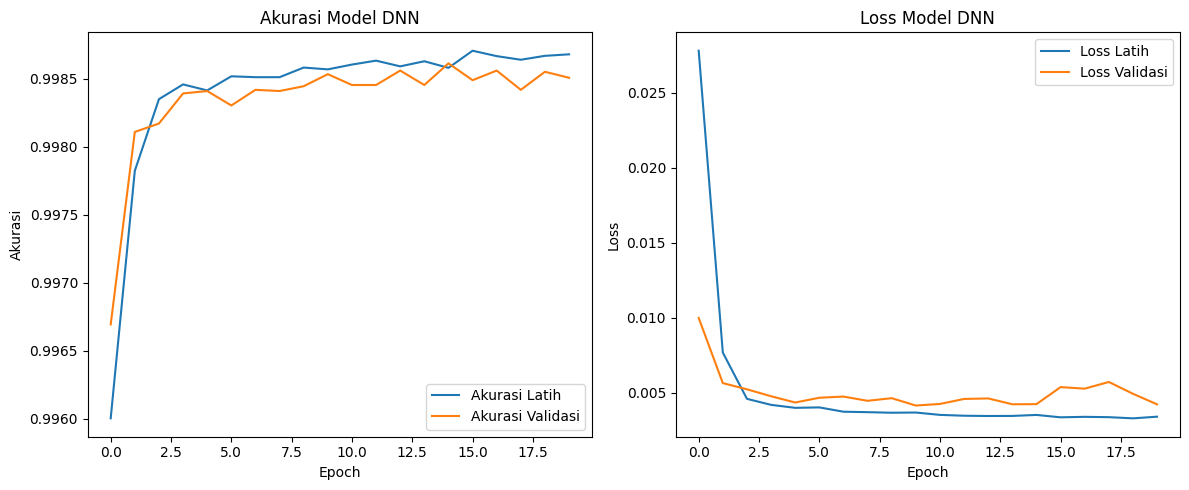

In [62]:
# Gunakan data test yang sudah direduksi dengan SVD
X_test_reduced = svd.transform(X_test_processed)

loss_dnn, accuracy_dnn = dnn_model.evaluate(X_test_reduced, y_test_one_hot, verbose=0)
print(f"[DNN] Loss: {loss_dnn:.4f} | Akurasi: {accuracy_dnn * 100:.2f}%")

# Plot DNN
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['accuracy'], label='Akurasi Latih')
plt.plot(history_dnn.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model DNN')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['loss'], label='Loss Latih')
plt.plot(history_dnn.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model DNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


[LSTM] Loss: 0.0038 | Akurasi: 99.85%


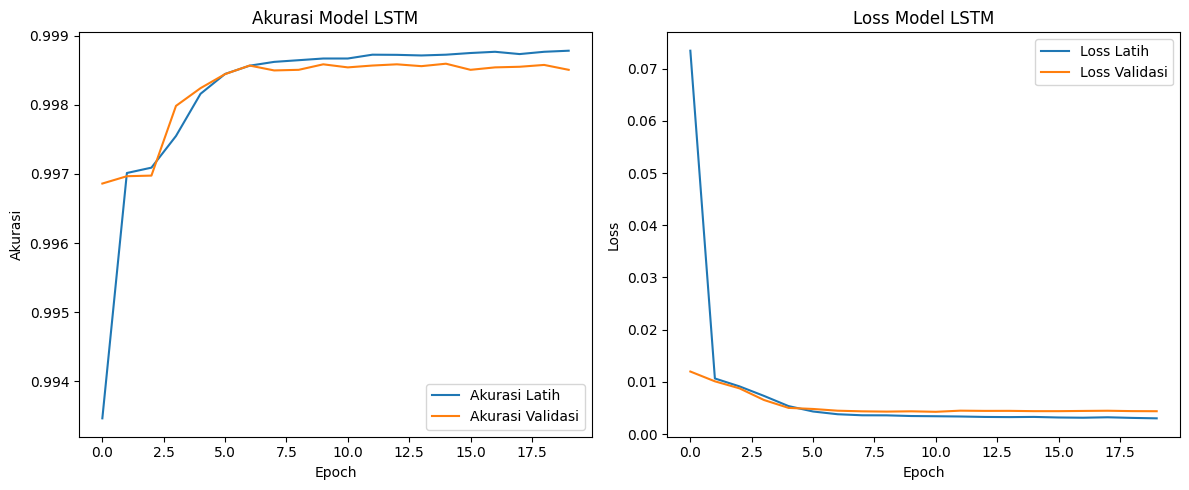

In [63]:
# Ubah X_test_reduced ke 3D untuk LSTM dan BiGRU
X_test_seq = X_test_reduced.reshape((X_test_reduced.shape[0], 1, X_test_reduced.shape[1]))

loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test_seq, y_test_one_hot, verbose=0)
print(f"[LSTM] Loss: {loss_lstm:.4f} | Akurasi: {accuracy_lstm * 100:.2f}%")

# Plot LSTM
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Akurasi Latih')
plt.plot(history_lstm.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model LSTM')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Loss Latih')
plt.plot(history_lstm.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


[BiGRU] Loss: 0.0038 | Akurasi: 99.85%


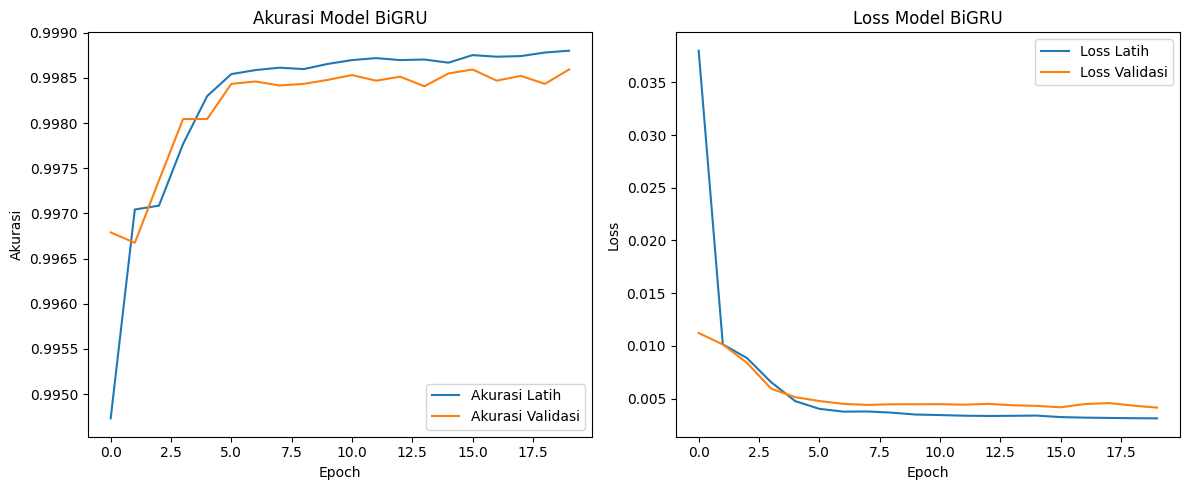

In [64]:
loss_bigru, accuracy_bigru = bigru_model.evaluate(X_test_seq, y_test_one_hot, verbose=0)
print(f"[BiGRU] Loss: {loss_bigru:.4f} | Akurasi: {accuracy_bigru * 100:.2f}%")

# Plot BiGRU
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bigru.history['accuracy'], label='Akurasi Latih')
plt.plot(history_bigru.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model BiGRU')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bigru.history['loss'], label='Loss Latih')
plt.plot(history_bigru.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model BiGRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


4418/4418 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step

Laporan Klasifikasi (DNN):
               precision    recall  f1-score   support

        [UNK]       0.00      0.00      0.00         0
  Brute Force       0.83      0.78      0.80       406
   DoS Attack       1.00      1.00      1.00     39306
Nmap Scanning       1.00      1.00      1.00    101043
       Normal       1.00      0.96      0.98       411
     Spoofing       0.51      0.75      0.60       193

     accuracy                           1.00    141359
    macro avg       0.72      0.75      0.73    141359
 weighted avg       1.00      1.00      1.00    141359



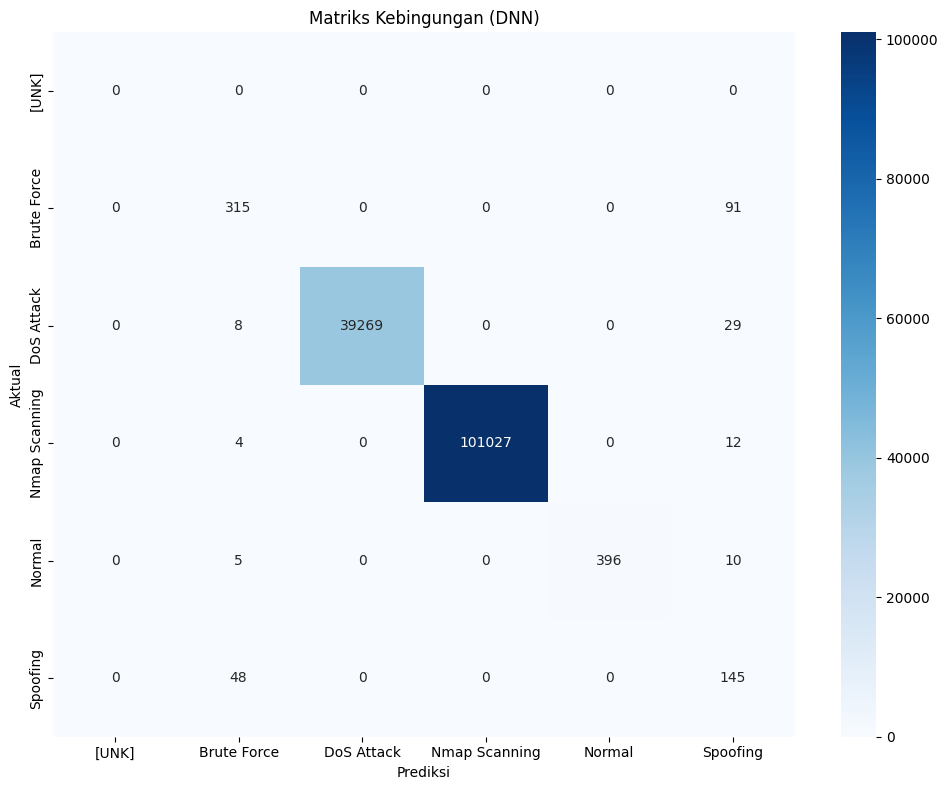

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ambil vocab dari StringLookup
vocab = label_encoder.get_vocabulary()

# Prediksi dari model (gunakan model yang aktif)
y_pred_prob = dnn_model.predict(X_test_reduced)  # Atau lstm_model.predict(X_test_seq)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test = np.argmax(y_test_one_hot, axis=1)

# Konversi indeks ke label asli (dari int ke string label)
y_test_labels = [vocab[i] for i in y_test]
y_pred_labels = [vocab[i] for i in y_pred]

# --- Laporan Klasifikasi ---
print("\nLaporan Klasifikasi (DNN):")
print(classification_report(
    y_test_labels,
    y_pred_labels,
    labels=vocab,           # penting: urutan label tetap
    target_names=vocab,
    zero_division=0
))

# --- Matriks Kebingungan ---
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=vocab)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=vocab, yticklabels=vocab)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Matriks Kebingungan (DNN)')
plt.tight_layout()
plt.show()



Evaluasi Model LSTM
4418/4418 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step
Laporan Klasifikasi (LSTM):
               precision    recall  f1-score   support

        [UNK]       0.00      0.00      0.00         0
  Brute Force       0.77      0.84      0.80       406
   DoS Attack       1.00      1.00      1.00     39306
Nmap Scanning       1.00      1.00      1.00    101043
       Normal       1.00      0.96      0.98       411
     Spoofing       0.54      0.62      0.57       193

     accuracy                           1.00    141359
    macro avg       0.72      0.74      0.73    141359
 weighted avg       1.00      1.00      1.00    141359



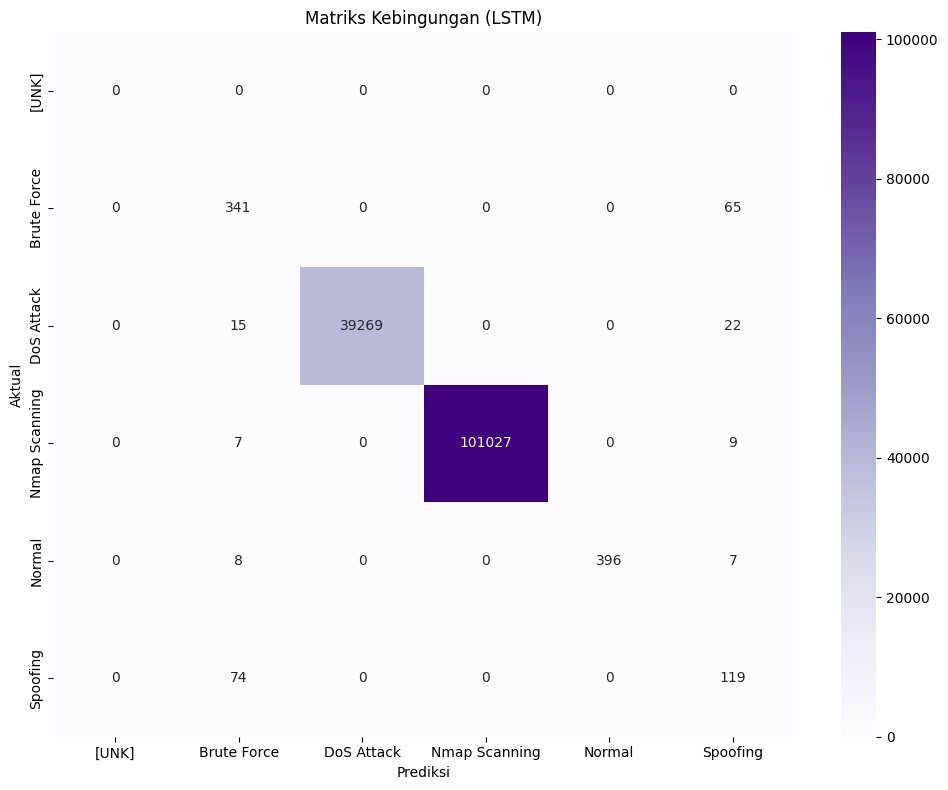


Evaluasi Model BiGRU
4418/4418 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
Laporan Klasifikasi (BiGRU):
               precision    recall  f1-score   support

        [UNK]       0.00      0.00      0.00         0
  Brute Force       0.79      0.83      0.81       406
   DoS Attack       1.00      1.00      1.00     39306
Nmap Scanning       1.00      1.00      1.00    101043
       Normal       1.00      0.96      0.98       411
     Spoofing       0.51      0.65      0.58       193

     accuracy                           1.00    141359
    macro avg       0.72      0.74      0.73    141359
 weighted avg       1.00      1.00      1.00    141359



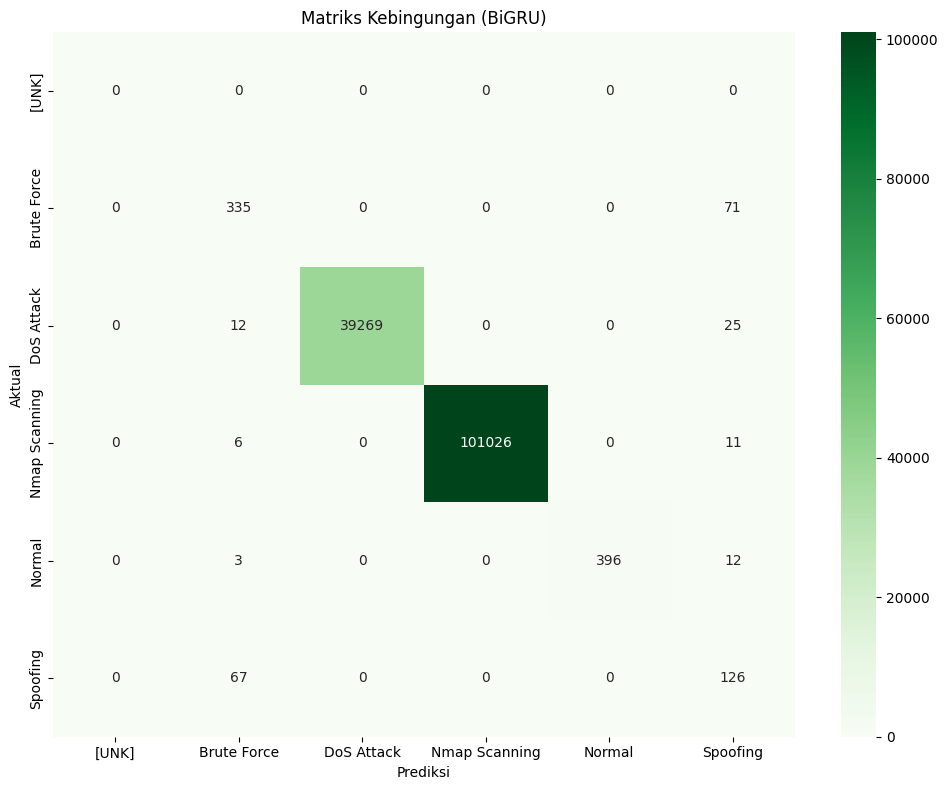

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ambil daftar label dari StringLookup
vocab = label_encoder.get_vocabulary()

# --- LSTM ---
print("\nEvaluasi Model LSTM")
y_pred_prob_lstm = lstm_model.predict(X_test_seq)
y_pred_lstm = np.argmax(y_pred_prob_lstm, axis=1)
y_test_true = np.argmax(y_test_one_hot, axis=1)

# Konversi indeks ke label string
y_test_labels = [vocab[i] for i in y_test_true]
y_pred_labels_lstm = [vocab[i] for i in y_pred_lstm]

# Laporan klasifikasi
print("Laporan Klasifikasi (LSTM):")
print(classification_report(
    y_test_labels,
    y_pred_labels_lstm,
    labels=vocab,
    target_names=vocab,
    zero_division=0
))

# Matriks Kebingungan LSTM
cm_lstm = confusion_matrix(y_test_labels, y_pred_labels_lstm, labels=vocab)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples',
            xticklabels=vocab, yticklabels=vocab)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Matriks Kebingungan (LSTM)')
plt.tight_layout()
plt.show()


# --- BiGRU ---
print("\nEvaluasi Model BiGRU")
y_pred_prob_bigru = bigru_model.predict(X_test_seq)
y_pred_bigru = np.argmax(y_pred_prob_bigru, axis=1)
y_pred_labels_bigru = [vocab[i] for i in y_pred_bigru]

# Laporan klasifikasi
print("Laporan Klasifikasi (BiGRU):")
print(classification_report(
    y_test_labels,
    y_pred_labels_bigru,
    labels=vocab,
    target_names=vocab,
    zero_division=0
))

# Matriks Kebingungan BiGRU
cm_bigru = confusion_matrix(y_test_labels, y_pred_labels_bigru, labels=vocab)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_bigru, annot=True, fmt='d', cmap='Greens',
            xticklabels=vocab, yticklabels=vocab)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Matriks Kebingungan (BiGRU)')
plt.tight_layout()
plt.show()


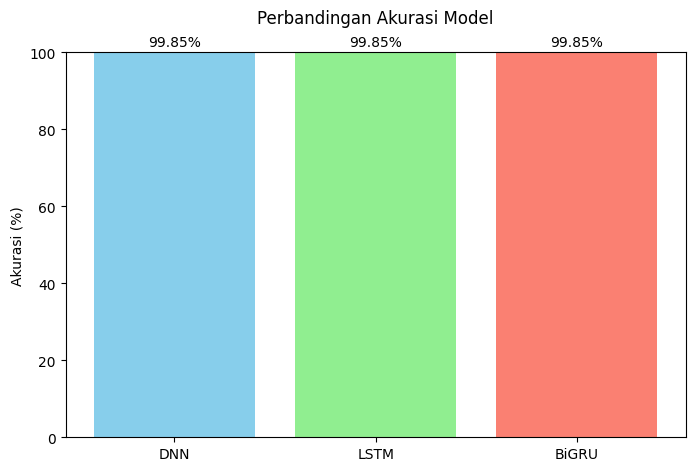

In [71]:
# Evaluasi semua model
loss_dnn, accuracy_dnn = dnn_model.evaluate(X_test_reduced, y_test_one_hot, verbose=0)
loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test_seq, y_test_one_hot, verbose=0)
loss_bigru, accuracy_bigru = bigru_model.evaluate(X_test_seq, y_test_one_hot, verbose=0)

# Siapkan untuk plot
model_names = ['DNN', 'LSTM', 'BiGRU']
accuracies = [accuracy_dnn, accuracy_lstm, accuracy_bigru]

# Plot bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, [a * 100 for a in accuracies], color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Akurasi (%)')
plt.ylim(0, 100)
plt.title('Perbandingan Akurasi Model\n')

# Tampilkan nilai di atas bar
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{acc*100:.2f}%', ha='center', va='bottom')

plt.show()


In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)  # ← gunakan data teks mentah

# Simpan feature names untuk SHAP
feature_names = vectorizer.get_feature_names_out()


PermutationExplainer explainer: 101it [00:17,  2.54it/s]                         


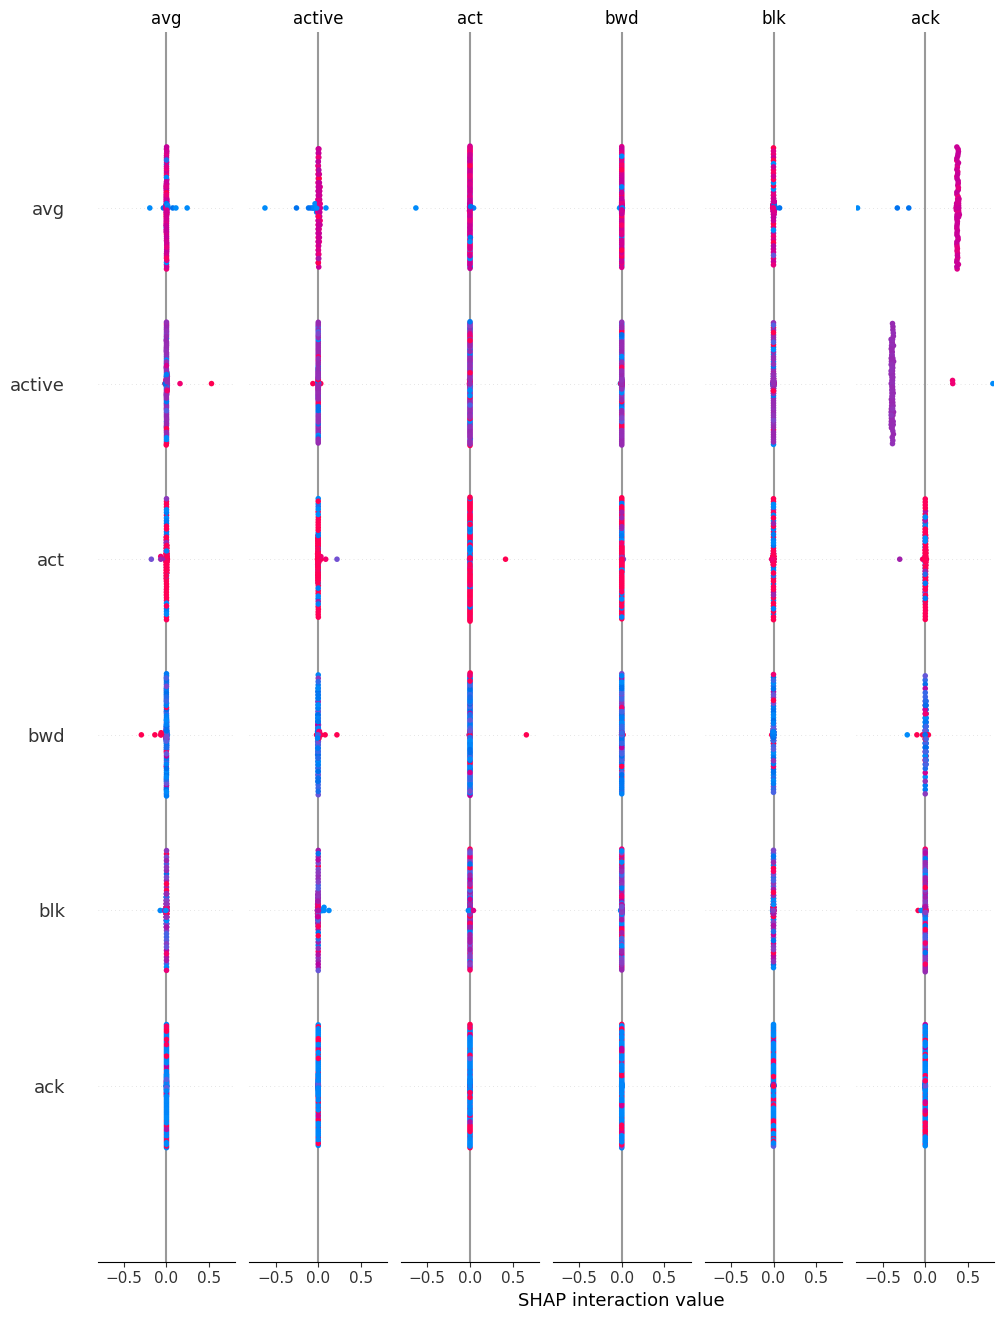

In [80]:
import shap

# SHAP untuk model DNN
explainer = shap.Explainer(dnn_model, X_test_reduced)
shap_values = explainer(X_test_reduced[:100])

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_reduced[:100], feature_names=feature_names, max_display=15)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


 10%|█         | 1/10 [00:20<03:00, 20.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


 20%|██        | 2/10 [00:39<02:36, 19.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step


 30%|███       | 3/10 [00:58<02:16, 19.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step 


 40%|████      | 4/10 [01:15<01:51, 18.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step 


 50%|█████     | 5/10 [01:33<01:30, 18.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step


 60%|██████    | 6/10 [01:52<01:14, 18.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step 


 70%|███████   | 7/10 [02:10<00:54, 18.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step 


 80%|████████  | 8/10 [02:27<00:36, 18.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


 90%|█████████ | 9/10 [02:47<00:18, 18.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step


100%|██████████| 10/10 [03:05<00:00, 18.59s/it]


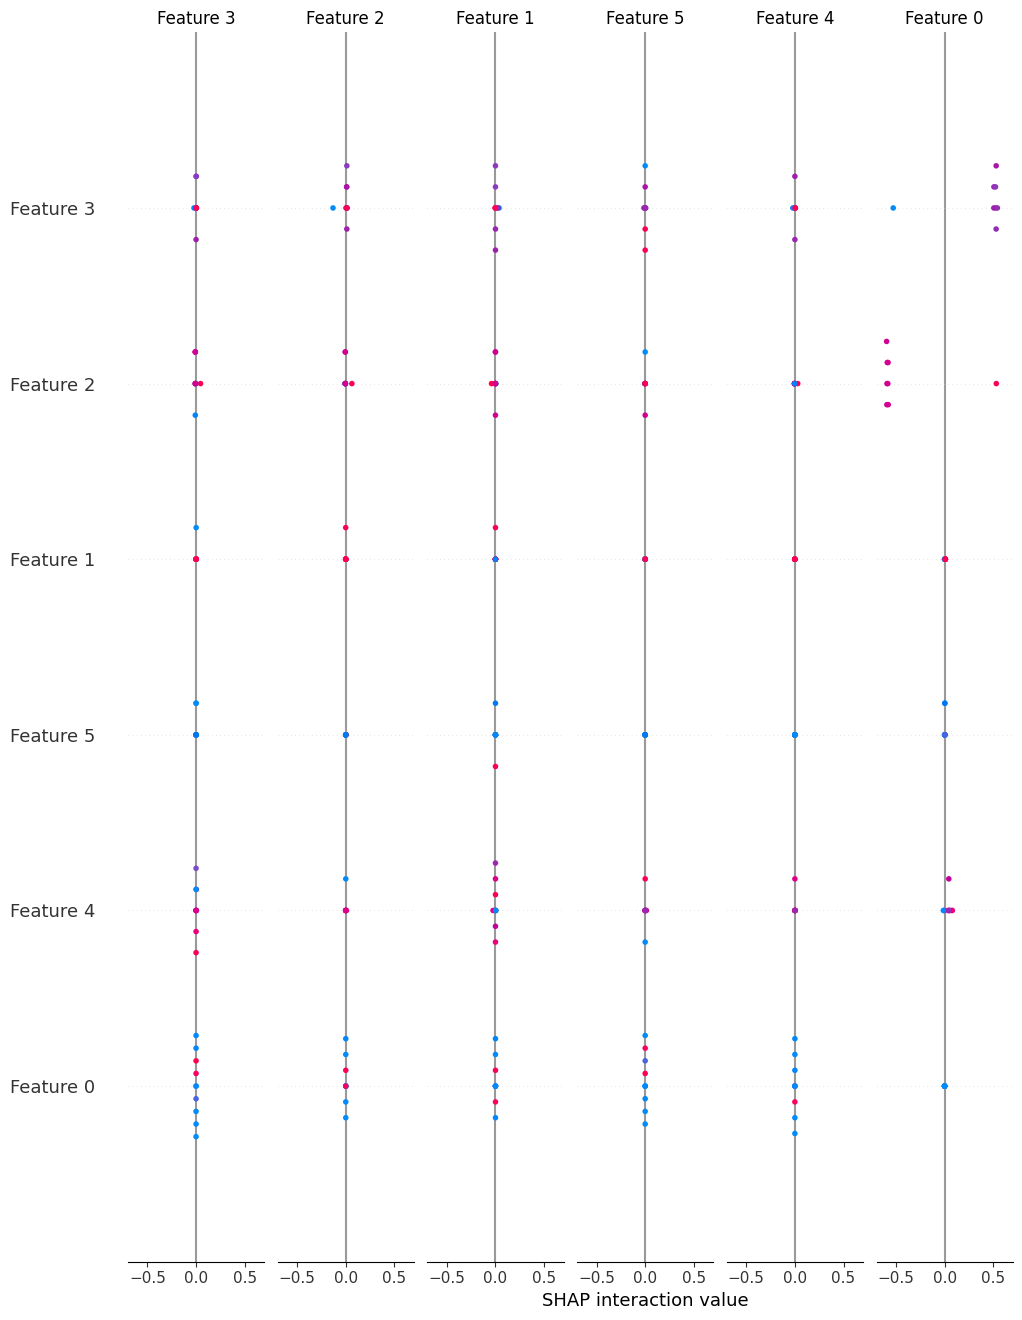

In [89]:
import shap
import numpy as np

# Ambil sampel data
sample_input_lstm = X_test_seq[:100]  # shape: (100, time_steps, dim)
background = sample_input_lstm[:50]   # shape: (50, time_steps, dim)

# Flatten input agar cocok dengan KernelExplainer
sample_input_flat = sample_input_lstm[:10].reshape((10, -1))         # jadi (10, time_steps * dim)
background_flat = background.reshape((50, -1))                       # jadi (50, time_steps * dim)

# Bungkus model untuk reshape kembali ke 3D saat prediksi
def model_predict_reshaped(x_flat):
    x_reshaped = x_flat.reshape((-1, sample_input_lstm.shape[1], sample_input_lstm.shape[2]))
    return lstm_model.predict(x_reshaped)

# Buat SHAP explainer
explainer_lstm = shap.KernelExplainer(model_predict_reshaped, background_flat)

# Hitung SHAP values (maks 10 sampel)
shap_values_lstm = explainer_lstm.shap_values(sample_input_flat)

# Visualisasi SHAP summary
shap.summary_plot(shap_values_lstm, sample_input_flat, max_display=15)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step


 10%|█         | 1/10 [00:23<03:31, 23.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step


 20%|██        | 2/10 [00:45<02:59, 22.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step


 30%|███       | 3/10 [01:07<02:37, 22.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step


 40%|████      | 4/10 [01:29<02:13, 22.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step


 50%|█████     | 5/10 [01:52<01:52, 22.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step


 60%|██████    | 6/10 [02:15<01:30, 22.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step


 70%|███████   | 7/10 [02:40<01:10, 23.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step


 80%|████████  | 8/10 [03:10<00:50, 25.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step


 90%|█████████ | 9/10 [03:39<00:26, 26.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
3825/3825 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step


100%|██████████| 10/10 [04:06<00:00, 24.70s/it]


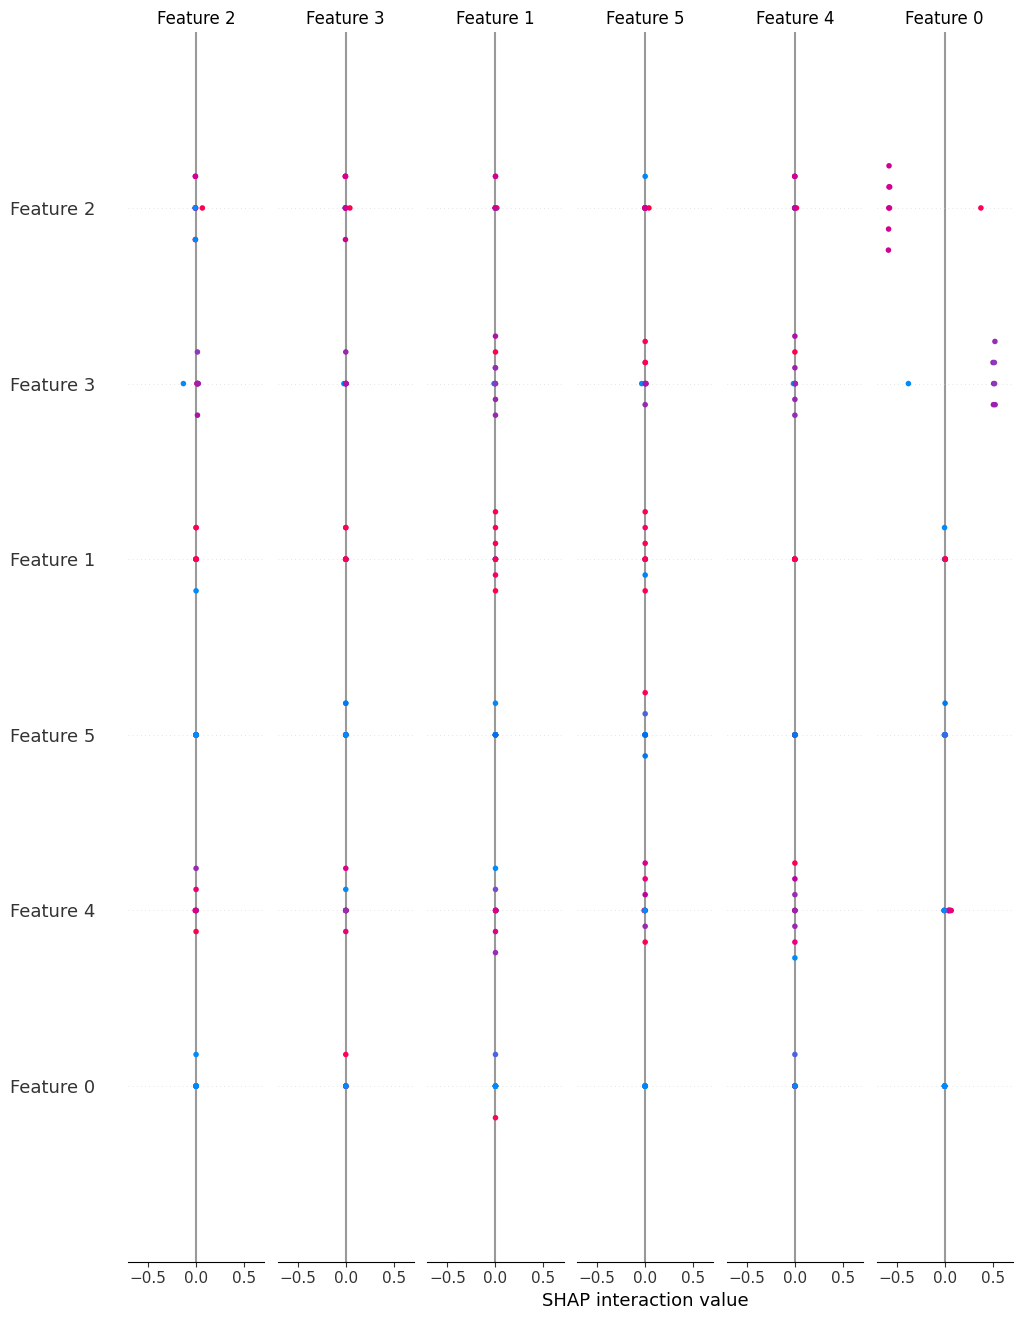

In [91]:
import shap
import numpy as np

# Ambil sampel data uji
sample_input_bigru = X_test_seq[:100]  # format (batch, timesteps, embedding_dim)
background_bigru = sample_input_bigru[:50]

# Flatten input jadi 2D agar bisa diproses KernelExplainer
sample_input_flat_bigru = sample_input_bigru[:10].reshape((10, -1))
background_flat_bigru = background_bigru.reshape((50, -1))

# Fungsi wrapper untuk reshaping kembali ke 3D sebelum prediksi
def predict_bigru(x_flat):
    x_reshaped = x_flat.reshape((-1, sample_input_bigru.shape[1], sample_input_bigru.shape[2]))
    return bigru_model.predict(x_reshaped)

# Inisialisasi SHAP KernelExplainer
explainer_bigru = shap.KernelExplainer(predict_bigru, background_flat_bigru)

# Hitung SHAP values untuk 10 sampel pertama
shap_values_bigru = explainer_bigru.shap_values(sample_input_flat_bigru)

# Plot SHAP summary
shap.summary_plot(shap_values_bigru, sample_input_flat_bigru, max_display=15)


In [93]:
# Simpan model
dnn_model.save('model_dnn_intrusi.keras')
print("Model DNN berhasil disimpan sebagai 'model_dnn_intrusi.keras'.")

lstm_model.save('model_lstm_intrusi.keras')
print("Model LSTM berhasil disimpan sebagai 'model_lstm_intrusi.keras'.")

bigru_model.save('model_bigru_intrusi.keras')
print("Model BiGRU berhasil disimpan sebagai 'model_bigru_intrusi.keras'.")

# Load kembali model
from tensorflow.keras.models import load_model

dnn_loaded = load_model('model_dnn_intrusi.keras')
lstm_loaded = load_model('model_lstm_intrusi.keras')
bigru_loaded = load_model('model_bigru_intrusi.keras')

print("Semua model berhasil dimuat ulang dari format .keras.")

Model DNN berhasil disimpan sebagai 'model_dnn_intrusi.keras'.
Model LSTM berhasil disimpan sebagai 'model_lstm_intrusi.keras'.
Model BiGRU berhasil disimpan sebagai 'model_bigru_intrusi.keras'.
Semua model berhasil dimuat ulang dari format .keras.


/opt/tljh/user/envs/dltf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/opt/tljh/user/envs/dltf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/opt/tljh/user/envs/dltf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [95]:
# Simpan model menggunakan model.export() (Keras 3)
dnn_model.export('saved_model/dnn')
print("Model DNN berhasil diekspor ke folder 'saved_model/dnn'.")

lstm_model.export('saved_model/lstm')
print("Model LSTM berhasil diekspor ke folder 'saved_model/lstm'.")

bigru_model.export('saved_model/bigru')
print("Model BiGRU berhasil diekspor ke folder 'saved_model/bigru'.")

INFO:tensorflow:Assets written to: saved_model/dnn/assets


INFO:tensorflow:Assets written to: saved_model/dnn/assets


Saved artifact at 'saved_model/dnn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200), dtype=tf.float32, name='keras_tensor_30')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140554613256080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554613250320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554613244560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554613254544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554613251280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554613250704: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model DNN berhasil diekspor ke folder 'saved_model/dnn'.
INFO:tensorflow:Assets written to: saved_model/lstm/assets


INFO:tensorflow:Assets written to: saved_model/lstm/assets


Saved artifact at 'saved_model/lstm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 200), dtype=tf.float32, name='keras_tensor_35')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140554630274256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554630275600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554630275984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554630274064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554630270608: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model LSTM berhasil diekspor ke folder 'saved_model/lstm'.
INFO:tensorflow:Assets written to: saved_model/bigru/assets


INFO:tensorflow:Assets written to: saved_model/bigru/assets


Saved artifact at 'saved_model/bigru'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 200), dtype=tf.float32, name='keras_tensor_39')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140554589755664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554589757584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554589762192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554589751632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554589764880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554589764112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554589758160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140554589764304: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model BiGRU berhasil diekspor ke folder 'saved_model/bigru'.


In [ ]:
from keras.layers import TFSMLayer
import tensorflow as tf

# Load model sebagai inference-only layer
dnn_loaded = TFSMLayer("saved_model/dnn", call_endpoint="serve")
lstm_loaded = TFSMLayer("saved_model/lstm", call_endpoint="serve")
bigru_loaded = TFSMLayer("saved_model/bigru", call_endpoint="serve")

# Misal kamu punya data input dengan shape sesuai model masing-masing:
import numpy as np

# Contoh input dummy
dnn_input = np.random.rand(1, 200).astype(np.float32)           # DNN: shape (None, 200)
lstm_input = np.random.rand(1, 1, 200).astype(np.float32)       # LSTM: shape (None, 1, 200)
bigru_input = np.random.rand(1, 1, 200).astype(np.float32)      # BiGRU: shape (None, 1, 200)

# Prediksi
dnn_output = dnn_loaded(dnn_input)
lstm_output = lstm_loaded(lstm_input)
bigru_output = bigru_loaded(bigru_input)

print("Prediksi DNN:", dnn_output.numpy())
print("Prediksi LSTM:", lstm_output.numpy())
print("Prediksi BiGRU:", bigru_output.numpy())


In [ ]:
import joblib
# Setelah preprocessor.fit_transform(X_train)
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl') # Simpan juga label encoder
print("Preprocessor dan Label Encoder berhasil disimpan sebagai 'preprocessor.pkl' dan 'label_encoder.pkl'")